### TODO:


1.   complete requirements.txt
2.   add plots code
3.   showing the results of fly image(optional)





# Importing needed libaries

In [ ]:
# Importing libarires
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import transforms
from torchvision.datasets.coco import CocoDetection
from torch.utils.data import DataLoader
from google.colab import drive
import shutil
import pyvww
import random
from sklearn.model_selection import train_test_split
from torchvision.transforms import RandomResizedCrop
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchinfo import summary
from bayes_opt import BayesianOptimization
import torch.optim.lr_scheduler



In [ ]:
# !pip install torchinfo
# !pip install pyvww
# !pip install bayesian-optimization

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Data and make it ready for next parts

In [ ]:
# Getting access to the goolge drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Unpack the COCO dataset and annotations from Google Drive
shutil.unpack_archive("/content/drive/MyDrive/project/coco_reduced/COCO.zip", "/content/sample_data/Coco")
shutil.unpack_archive("/content/drive/MyDrive/project/kevin_annotations/annotations.zip", "/content/sample_data/annotations_new")

In [ ]:
# Custom Dataset class for the balanced dataset
class BalancedVisualWakeWordsDataset(torch.utils.data.Dataset):
    def __init__(self, visual_wake_words_dataset):
        self.visual_wake_words_dataset = visual_wake_words_dataset

    def __getitem__(self, index):
        return self.visual_wake_words_dataset[index]

    def __len__(self):
        return len(self.visual_wake_words_dataset)

# Function to create a balanced dataset with an equal number of positive and negative samples
def create_balanced_dataset(dataset, target_class=1):
    positive_data = []
    negative_data = []

    # Separate positive and negative samples
    for img, target in dataset:
        if target == target_class:
            positive_data.append((img, target))
        else:
            negative_data.append((img, target))

    # Balance the dataset by selecting an equal number of positive and negative samples
    num_samples = min(len(positive_data), len(negative_data))
    positive_data = random.sample(positive_data, num_samples)
    negative_data = random.sample(negative_data, num_samples)

    # Combine and shuffle the balanced data
    balanced_data = positive_data + negative_data
    random.shuffle(balanced_data)

    return balanced_data

# Define the data augmentation transformations
augmented_data_transform = transforms.Compose([
    transforms.Resize(size=(96, 96)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    RandomResizedCrop(size=(96, 96), scale=(0.8, 1.0), ratio=(3/4, 4/3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ConvertImageDtype(torch.float16),
])

# Load the COCO dataset with the custom data transformations
train_data = pyvww.pytorch.VisualWakeWordsClassification(
    root="/content/sample_data/Coco/all2014",
    annFile="/content/sample_data/annotations_new/annotations/instances_train.json",
    transform=augmented_data_transform
)
val_data = pyvww.pytorch.VisualWakeWordsClassification(
    root="/content/sample_data/Coco/all2014",
    annFile="/content/sample_data/annotations_new/annotations/instances_val.json",
    transform=augmented_data_transform
)

# Combine train and validation datasets
combined_data = train_data + val_data

# Create a balanced combined dataset
balanced_combined_data = create_balanced_dataset(combined_data)

# Split the combined data into train, validation, and test datasets
train_data_filtered, temp_data_filtered = train_test_split(balanced_combined_data, test_size=0.3, random_state=42)
val_data_filtered, test_data_filtered = train_test_split(temp_data_filtered, test_size=0.5, random_state=42)

# Wrap the filtered data in the custom dataset class
train_dataset = BalancedVisualWakeWordsDataset(train_data_filtered)
val_dataset = BalancedVisualWakeWordsDataset(val_data_filtered)
test_dataset = BalancedVisualWakeWordsDataset(test_data_filtered)

loading annotations into memory...
Done (t=4.69s)
creating index...
index created!
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


## Visualizing ten random images with their labels

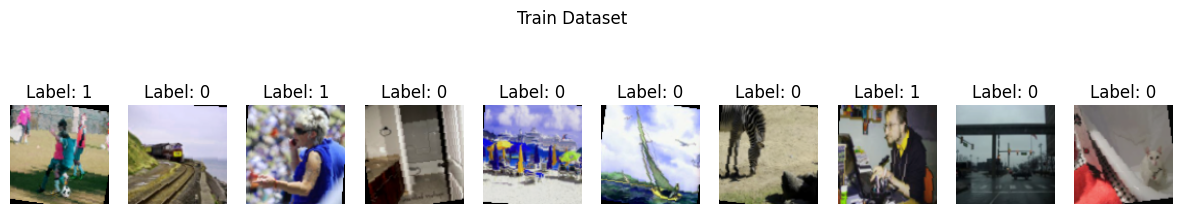

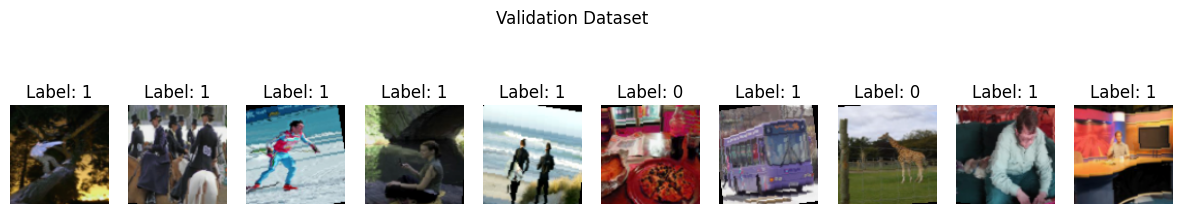

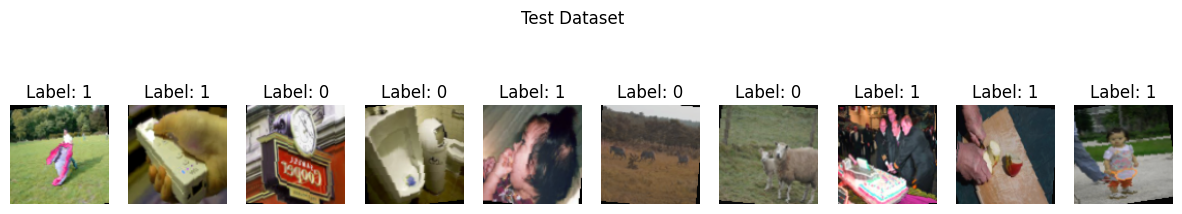

In [ ]:
# to have better results of image we used unnomalized images
def unnormalize(img_tensor, mean, std):
    img_np = img_tensor.numpy().transpose((1, 2, 0)).astype(np.float32)
    img_np = img_np * np.array(std) + np.array(mean)
    img_np = np.clip(img_np, 0, 1)  # Clip the values to the valid range [0, 1]
    return img_np

# Plot a specified number of random images from a given dataset
def plot_random_images(dataset, title, num_images=10, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(title)

    for ax in axes:
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img_np = unnormalize(img, mean, std)  # Unnormalize the image

        ax.imshow(img_np)
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.show()

# Plot 10 random images from each dataset
plot_random_images(train_dataset, "Train Dataset")
plot_random_images(val_dataset, "Validation Dataset")
plot_random_images(test_dataset, "Test Dataset")

# Defining helper functions

In [ ]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, num_epochs, batch_size, learning_rate, train_dataset, val_dataset, test_dataset, device):

    # Train function with gradient clipping
    def train(model, dataloader, criterion, optimizer, device, grad_clip=1.0):
        # Move the model to the specified device and set it to training mode
        model.to(device).train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop over the training dataset
        for inputs, labels in tqdm(dataloader, desc="Training"):
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, compute the output of the model
            outputs = model(inputs)
            # Compute the loss between the output and the labels
            loss = criterion(outputs, labels)
            # Backward pass, compute the gradients w.r.t the loss
            loss.backward()

            # Apply gradient clipping to model parameters
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # Update the model parameters using the optimizer
            optimizer.step()

            # Update the running loss and accuracy statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Compute the average epoch loss and accuracy
        epoch_loss = running_loss / len(dataloader)
        accuracy = 100 * correct / total
        return epoch_loss, accuracy

    # Validation function
    def validate(model, dataloader, criterion, device):
        # Set the model to evaluation mode
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop over the validation dataset without computing gradients
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Validation"):
                # Move inputs and labels to the specified device
                inputs, labels = inputs.to(device), labels.to(device)

                # Compute the output of the model
                outputs = model(inputs)
                # Compute the loss between the output and the labels
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy statistics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Compute the average epoch loss and accuracy
        epoch_loss = running_loss / len(dataloader)
        accuracy = 100 * correct / total
        return epoch_loss, accuracy

    # Test function
    def test(model, dataloader, device):
        # Set the model to evaluation mode
        model.eval()
        correct = 0
        total = 0

        # Loop over the test dataset without computing gradients
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Testing"):
                # Move inputs and labels to the specified device
                inputs, labels = inputs.to(device), labels.to(device)

                # Compute the output of the model
                outputs = model(inputs)
                # Determine the predicted class
                _, predicted = outputs.max(1)
                # Update the accuracy statistics
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Compute the overall test accuracy
        accuracy = 100 * correct / total
        return accuracy

    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # Create data loaders for training, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize variables for tracking the best validation loss and early stopping
    best_val_loss = float('inf')
    patience = 5
    counter = 0

    # Training and validation loop
    for epoch in range(num_epochs):
        # Train the model and calculate training loss and accuracy
        train_loss, train_acc = train(model.half(), train_loader, criterion,optimizer, device)

        # Validate the model and calculate validation loss and accuracy
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Update the learning rate scheduler
        scheduler.step(val_loss)

        # Print the training and validation results for the current epoch
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Save the best model state based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model_name = type(model).__name__
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
            counter = 0
        else:
            # If the validation loss has not improved, increment the early stopping counter
            counter += 1

            # If the early stopping counter reaches the specified patience, stop training
            if counter >= patience:
                print("Early stopping triggered. Stopping training.")
                break

    # Load the best model state
    model.load_state_dict(torch.load(f'{model_name}_best_model.pth'))

    # Test the best model on the test dataset
    test_acc = test(model, test_loader, device)
    print(f"Test Accuracy: {test_acc:.2f}%")

    return model

    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # Create data loaders for training, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize variables for tracking the best validation loss and early stopping
    best_val_loss = float('inf')
    patience = 5
    counter = 0

    # Training and validation loop
    for epoch in range(num_epochs):
        # Train the model and calculate training loss and accuracy
        train_loss, train_acc = train(model.half(), train_loader, criterion, optimizer, device)
        # Validate the model and calculate validation loss and accuracy
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        # Print the results for this epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
        # Update the learning rate based on validation loss
        scheduler.step(val_loss)

        # Check if the current validation loss is the best so far
        if val_loss < best_val_loss:
            # Update the best validation loss and reset the counter
            best_val_loss = val_loss
            counter = 0
            # Save the current model state
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            # If validation loss didn't improve, increment the counter
            counter += 1
            # If the counter reaches the patience limit, stop training
            if counter >= patience:
                print("Early stopping")
                break

    # Load the best model state and test it on the test set
    model.load_state_dict(torch.load('best_model.pth'))
    test_acc = test(model, test_loader, device)
    print(f"Test accuracy: {test_acc:.2f}")

    return model, test_acc

In [ ]:
def compute_naswot(
    net: nn.Module,
    inputs: torch.Tensor,
    device: torch.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ) -> float:
    """Computes the NASWOT score for a given network

    Args:
        net (nn.Module): Actual network to be scored according to naswot.
        inputs (torch.Tensor): Tensor of size `batch_size` corresponding to the images forwarded as input.
        device (torch.device): Either CPU or GPU device.
    """
    # gradients are completely useless here
    with torch.no_grad():
        # result of hooks
        cs = list()

        def naswot_hook(module: nn.Module, module_input: torch.Tensor, module_output: torch.Tensor) -> None:
            """
            This function hooks an extra-operation to forward pass of module `m`.

            Args:
                module (nn.Module): layer in neural network
                module_input (torch.Tensor): input to the considered module. Size dependent on the actual module.
                module_output (torch.Tensor): output to the considered module. Size dependendant on the actual module.
            """
            code = (module_output > 0).flatten(start_dim=1)  # binarize output to True/False whether not zero or zero.
            cs.append(code)  # store embedding

        # storing applied hooks to remove them from array when they are not needed anymore
        hooks = list()
        for m in net.modules():
            if isinstance(m, nn.ReLU):  # naswot is defined for ReLU only layers
                hooks.append(m.register_forward_hook(naswot_hook))  # register naswot hook for ReLU layers

        net.to(device)
        inputs = inputs.to(device)
        # populating cs with the ReLU embeddings
        _ = net(inputs)

        # removing hooks once they have been used
        for h in hooks:
            h.remove()

        # False-True embedding of the whole network, discarding non ReLU layers
        full_code = torch.cat(cs, dim=1)

        # codes and network output not needed
        del cs, _
        # mapping False->0 / True->1
        full_code_float = full_code.float()
        # number of concordances between the embeddings of `inputs`
        k = full_code_float @ full_code_float.t()
        # not needed anymore
        del full_code_float
        # mapping each False->1 / True->0
        not_full_code_float = torch.logical_not(full_code).float()
        # hamming distance is number of disagreements = size of array - number of agreements
        k += not_full_code_float @ not_full_code_float.t()
        # naswot score computed on k
        naswot_score = torch.slogdet(k).logabsdet.item()
        if naswot_score == float('-inf'):
            naswot_score = 1e-6

        return naswot_score


In [ ]:
#@title
def check_hyperparameters(params):
    violated_conditions = []

    # Check if the number of filters increases from layer 4 to layer 6
    prev_filters = params["number_of_filters4"]
    for i in range(5, 7):
        curr_filters = params[f"number_of_filters{i}"]
        if curr_filters < prev_filters:
            violated_conditions.append(f"Condition 1 (Layer {i})")
        prev_filters = curr_filters

    # Check if the kernel size is 3x3 or 5x5 for layers 4 to 6
    for i in range(4, 7):
        kernel_size = params[f"kernel_size{i}"]
        if kernel_size not in (3, 5):
            violated_conditions.append(f"Condition 2 (Layer {i})")

    # Check if the padding is 1 or 2 for layers 4 to 6
    for i in range(4, 7):
        padding = params[f"padding{i}"]
        if padding not in (1, 2):
            violated_conditions.append(f"Condition 3 (Layer {i})")

    # Check if the dropout rate is between 0.1 and 0.3 for layers 4 to 6
    dropout_rates = [0.1, 0.2, 0.3]
    for i in range(4, 7):
        dropout_rate = params[f"dropout_rate{i}"]
        if dropout_rate not in dropout_rates:
            violated_conditions.append(f"Condition 4 (Layer {i})")

    # Check if the max pooling kernel size is 2x2 or 3x3 and the stride is 2 for layers 4 to 6
    for i in range(4, 7):
        max_pooling_kernel_size = params[f"max_pooling_kernel_size{i}"]
        max_pooling_stride = params[f"max_pooling_stride{i}"]
        if max_pooling_kernel_size not in (2, 3) or max_pooling_stride != 2:
            violated_conditions.append(f"Condition 5 (Layer {i})")

    # Check if the number of filters for layer 10 is 64, 128, or 256
    filters = [64, 128, 256]
    if params["number_of_filters10"] not in filters:
        violated_conditions.append("Condition 6")

    # Check if there are 2 or 3 fully connected layers
    fc_layers = [2, 3]
    if params["number_of_fc_layers"] not in fc_layers:
        violated_conditions.append("Condition 7")

    # Check if there are 32-128 neurons per fully connected layer
    fc_neurons = [32, 64, 96, 128]
    if params["number_of_neurons_per_fc_layer"] not in fc_neurons:
        violated_conditions.append("Condition 8")

    # Check if the fully connected dropout rate is between 0.2 and 0.4
    fc_dropout = [0.2, 0.3, 0.4]
    if params["dropout_rate_fc"] not in fc_dropout:
        violated_conditions.append("Condition 9")

    # If any conditions are violated, print them and return False
    if violated_conditions:
        print("Violated conditions:", violated_conditions)
        return False

    # If all conditions are met, return True
    return True

# Generate models based on a predefined search space and identify the best ones based on specified metrics.

In [ ]:
import torch
import torch.nn as nn

# Define a custom deep neural network class that inherits from torch.nn.Module
class CustomDNN(nn.Module):
    def __init__(self, hyperparams):
        super(CustomDNN, self).__init__()

        # Create a sequential container for the convolutional blocks
        self.blocks = nn.Sequential()
        # Add the specified number of convolutional blocks to the container
        for i in range(4, 7):
            # Determine the number of input channels for the current block
            in_channels = hyperparams[f"number_of_filters{i - 1}"] if i > 4 else 3
            # Get the other hyperparameters for the current block
            out_channels = hyperparams[f"number_of_filters{i}"]
            kernel_size = hyperparams[f"kernel_size{i}"]
            padding = hyperparams[f"padding{i}"]
            dropout_rate = hyperparams[f"dropout_rate{i}"]
            max_pooling_kernel_size = hyperparams[f"max_pooling_kernel_size{i}"]
            max_pooling_stride = hyperparams[f"max_pooling_stride{i}"]

            # Add the current block to the container using the specified hyperparameters
            self.blocks.add_module(f"block{i}", nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.MaxPool2d(max_pooling_kernel_size, stride=max_pooling_stride)
            ))

        # Create a sequential container for the fully connected layers
        self.fc = nn.Sequential()
        # Calculate the number of input features for the first fully connected layer
        in_features = hyperparams["final_conv_output_size"]  # You need to calculate this value
        # Add the specified number of fully connected layers to the container
        for i in range(hyperparams["number_of_fc_layers"]):
            out_features = hyperparams["number_of_neurons_per_fc_layer"]
            self.fc.add_module(f"fc{i}", nn.Linear(in_features, out_features))
            self.fc.add_module(f"relu{i}", nn.ReLU(inplace=True))
            in_features = out_features

        # Add a dropout layer and the output layer with the specified number of classes
        self.fc.add_module("dropout_fc", nn.Dropout(hyperparams["dropout_rate_fc"]))
        self.fc.add_module("output", nn.Linear(in_features, 2))  # Change 2 to the number of classes
        self.fc.add_module("softmax", nn.Softmax(dim=1))

    # Define the forward pass of the network
    def forward(self, x):
        # Pass the input through the convolutional blocks
        x = self.blocks(x)
        # Flatten the output of the blocks
        x = x.view(x.size(0), -1)
        # Pass the flattened output through the fully connected layers
        x = self.fc(x)
        return x

In [ ]:
def check_hyperparameters(params):
    violated_conditions = []

    # Condition 1: Number of filters increases
    prev_filters = params["number_of_filters4"]
    for i in range(5, 7):
        curr_filters = params[f"number_of_filters{i}"]
        if curr_filters < prev_filters:
            violated_conditions.append(f"Condition 1 (Layer {i})")
        prev_filters = curr_filters

    # Condition 2: Kernel size is 3x3 or 5x5
    for i in range(4, 7):
        kernel_size = params[f"kernel_size{i}"]
        if kernel_size not in (3, 5):
            violated_conditions.append(f"Condition 2 (Layer {i})")

    # Condition 3: Padding is 1 or 2
    for i in range(4, 7):
        padding = params[f"padding{i}"]
        if padding not in (1, 2):
            violated_conditions.append(f"Condition 3 (Layer {i})")

    # Condition 4: Dropout rate between 0.1 and 0.3
    dropout_rates = [0.1, 0.2, 0.3]
    for i in range(4, 7):
        dropout_rate = params[f"dropout_rate{i}"]
        if dropout_rate not in dropout_rates:
            violated_conditions.append(f"Condition 4 (Layer {i})")

    # Condition 5: Max pooling kernel size is 2x2 or 3x3 and stride is 2
    for i in range(4, 7):
        max_pooling_kernel_size = params[f"max_pooling_kernel_size{i}"]
        max_pooling_stride = params[f"max_pooling_stride{i}"]
        if max_pooling_kernel_size not in (2, 3) or max_pooling_stride != 2:
            violated_conditions.append(f"Condition 5 (Layer {i})")

    # Condition 6: number_of_filters10 is 64, 128 or 256
    filters = [64, 128, 256]
    if params["number_of_filters10"] not in filters:
        violated_conditions.append("Condition 6")

    # Condition 7: 2 or 3 fully connected layers
    fc_layers = [2, 3]
    if params["number_of_fc_layers"] not in fc_layers:
        violated_conditions.append("Condition 7")

    # Condition 8: 32-128 neurons per fully connected layer
    fc_neurons = [32, 64, 96, 128]
    if params["number_of_neurons_per_fc_layer"] not in fc_neurons:
        violated_conditions.append("Condition 8")

    # Condition 9: FC dropout rate between 0.2 and 0.4
    fc_dropout = [0.2, 0.3, 0.4]
    if params["dropout_rate_fc"] not in fc_dropout:
        violated_conditions.append("Condition 9")

    # If any conditions are violated, print them and return False
    if violated_conditions:
        print("Violated conditions:", violated_conditions)
        return False

    # If all conditions are met, return True
    return True

In [ ]:
search_space = {
    "number_of_filters4": (16, 64),
    "number_of_filters5": (32, 128),
    "number_of_filters6": (64, 256),
    "kernel_size4": [3, 5],
    "kernel_size5": [3, 5],
    "kernel_size6": [3, 5],
    "padding4": [1, 2],
    "padding5": [1, 2],
    "padding6": [1, 2],
    "dropout_rate4": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "dropout_rate5": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "dropout_rate6": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "max_pooling_kernel_size4": [2, 3],
    "max_pooling_kernel_size5": [2, 3],
    "max_pooling_kernel_size6": [2, 3],
    "max_pooling_stride4": [1, 2],
    "max_pooling_stride5": [1, 2],
    "max_pooling_stride6": [1, 2],
    "dropout_rate_fc": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "number_of_filters10": [32, 64, 128, 256, 512],
    "number_of_fc_layers": [1, 2, 3],
    "number_of_neurons_per_fc_layer": [16, 32, 64, 128],
}

In [ ]:
def generate_hyperparameters(search_space):
    hyperparameters = {
        "number_of_filters4": random.randint(*search_space["number_of_filters4"]),
        "number_of_filters5": random.randint(*search_space["number_of_filters5"]),
        "number_of_filters6": random.randint(*search_space["number_of_filters6"]),
        "kernel_size4": random.choice(search_space["kernel_size4"]),
        "kernel_size5": random.choice(search_space["kernel_size5"]),
        "kernel_size6": random.choice(search_space["kernel_size6"]),
        "padding4": random.choice(search_space["padding4"]),
        "padding5": random.choice(search_space["padding5"]),
        "padding6": random.choice(search_space["padding6"]),
        "dropout_rate4": random.choice(search_space["dropout_rate4"]),
        "dropout_rate5": random.choice(search_space["dropout_rate5"]),
        "dropout_rate6": random.choice(search_space["dropout_rate6"]),
        "max_pooling_kernel_size4": random.choice(search_space["max_pooling_kernel_size4"]),
        "max_pooling_kernel_size5": random.choice(search_space["max_pooling_kernel_size5"]),
        "max_pooling_kernel_size6": random.choice(search_space["max_pooling_kernel_size6"]),
        "max_pooling_stride4": random.choice(search_space["max_pooling_stride4"]),
        "max_pooling_stride5": random.choice(search_space["max_pooling_stride5"]),
        "max_pooling_stride6": random.choice(search_space["max_pooling_stride6"]),
        "dropout_rate_fc": random.choice(search_space["dropout_rate_fc"]),
        "number_of_filters10": random.choice(search_space["number_of_filters10"]),
        "number_of_fc_layers": random.choice(search_space["number_of_fc_layers"]),
        "number_of_neurons_per_fc_layer": random.choice(search_space["number_of_neurons_per_fc_layer"]),
    }
    return hyperparameters

In [ ]:
def calculate_final_conv_output_size(input_size, hyperparams):
    output_size = input_size
    # Iterate through the 4th, 5th, and 6th layers
    for i in range(4, 7):
        # Get the kernel_size, padding, max_pooling_kernel_size, and max_pooling_stride for the current layer
        kernel_size = hyperparams[f"kernel_size{i}"]
        padding = hyperparams[f"padding{i}"]
        max_pooling_kernel_size = hyperparams[f"max_pooling_kernel_size{i}"]
        max_pooling_stride = hyperparams[f"max_pooling_stride{i}"]

        # Calculate the output size after the convolutional layer
        # Formula: (W - K + 2P) / S + 1, where W is input size,
        # K is kernel size, P is padding, and S is stride (1 in this case)
        output_size = (output_size + 2 * padding - kernel_size) // 1 + 1

        # Calculate the output size after the max pooling layer
        # Formula: (W - K) / S + 1, where W is input size,
        # K is max_pooling_kernel_size, and S is max_pooling_stride
        output_size = (output_size - max_pooling_kernel_size) // max_pooling_stride + 1

    # Return the final output size (flattened) by multiplying the output_size by itself
    # and by the number of filters in the 6th convolutional layer
    return output_size**2 * hyperparams["number_of_filters6"]

## First metric for finding best model : Naswot_score

In [ ]:
# Set the number of models to store
MAX_MODELS = 200
# Set the maximum number of retries to generate valid hyperparameters
MAX_RETRIES = 20000
# Set the input image size
input_image_size = 96
# Initialize an empty list to store the generated models
models = []

# Continue generating models until the desired number of models is reached
while len(models) < MAX_MODELS:
    # Retry generating valid hyperparameters up to the maximum number of retries
    for i in range(MAX_RETRIES):
        # Generate a set of hyperparameters from the search space
        hyperparameters = generate_hyperparameters(search_space)
        # Check if the generated hyperparameters are valid
        if check_hyperparameters(hyperparameters):
            # Calculate the final output size of the last convolutional layer
            final_conv_output_size = calculate_final_conv_output_size(input_image_size, hyperparameters)
            # Add the final output size to the hyperparameters dictionary
            hyperparameters["final_conv_output_size"] = final_conv_output_size
            print(f'Generated model {len(models)} at attempt {i}')
            # Create a new model with the given hyperparameters
            model = CustomDNN(hyperparameters)
            # Add the model to the list of models
            models.append(model)
            break

# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# Set the device for model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize empty lists to store NASWOT scores and correlations
naswot_scores = []

# Evaluate each model and calculate its NASWOT score
for i, model in enumerate(models):
    # Get a batch of input data and ignore the corresponding labels
    input, _ = next(iter(train_loader))
    # Move the input data to the current device
    input = input.to(device)
    # Calculate the NASWOT score for the current model
    naswot_score = compute_naswot(model.half().to(device), input, device)
    # Add the NASWOT score to the list of scores
    naswot_scores.append(naswot_score)
    print(f"NASWOT score for model {i}: {naswot_score}")

# Rank the models based on their NASWOT scores
ranked_models = sorted(zip(naswot_scores, models), key=lambda x: x[0])

# Print the ranked models and their NASWOT scores
print("Ranked models:")
for i, (score, model) in enumerate(ranked_models):
    print(f"{i + 1}. Model {models.index(model)}, NASWOT score: {score}")

# Choose the model with the highest NASWOT score
best_score, best_model_naswot = ranked_models[-1]
print(f"Best model: Model {models.index(best_model_naswot)}, NASWOT score: {best_score}")

Streaming output truncated to the last 5000 lines.
Violated conditions: ['Condition 5 (Layer 4)', 'Condition 5 (Layer 6)', 'Condition 6', 'Condition 8']
Violated conditions: ['Condition 4 (Layer 6)', 'Condition 5 (Layer 4)', 'Condition 5 (Layer 5)', 'Condition 5 (Layer 6)', 'Condition 7']
Violated conditions: ['Condition 1 (Layer 5)', 'Condition 5 (Layer 4)', 'Condition 5 (Layer 6)', 'Condition 7', 'Condition 9']
Violated conditions: ['Condition 4 (Layer 4)', 'Condition 4 (Layer 5)', 'Condition 5 (Layer 5)', 'Condition 9']
Violated conditions: ['Condition 4 (Layer 4)', 'Condition 5 (Layer 6)', 'Condition 9']
Violated conditions: ['Condition 4 (Layer 4)', 'Condition 4 (Layer 5)', 'Condition 4 (Layer 6)', 'Condition 5 (Layer 6)', 'Condition 6', 'Condition 8', 'Condition 9']
Violated conditions: ['Condition 4 (Layer 4)', 'Condition 4 (Layer 6)', 'Condition 5 (Layer 5)']
Violated conditions: ['Condition 4 (Layer 4)', 'Condition 5 (Layer 6)', 'Condition 9']
Violated conditions: ['Condition 

In [ ]:
summary(best_model_naswot)

Layer (type:depth-idx)                   Param #
CustomDNN                                --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,764
│    │    └─BatchNorm2d: 3-2             126
│    │    └─ReLU: 3-3                    --
│    │    └─Dropout: 3-4                 --
│    │    └─MaxPool2d: 3-5               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-6                  197,000
│    │    └─BatchNorm2d: 3-7             250
│    │    └─ReLU: 3-8                    --
│    │    └─Dropout: 3-9                 --
│    │    └─MaxPool2d: 3-10              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-11                 257,854
│    │    └─BatchNorm2d: 3-12            458
│    │    └─ReLU: 3-13                   --
│    │    └─Dropout: 3-14                --
│    │    └─MaxPool2d: 3-15              --
├─Sequential: 1-2                        --
│    └─Line

## Second metric for finding best model : ***

In [ ]:
import torch.nn as nn
import numpy as np
from bayes_opt import BayesianOptimization

# Calculate the output shape of a convolutional layer
def calculate_output_shape(input_shape, kernel_size, padding, stride):
    output_height = (input_shape[0] - kernel_size[0] + 2 * padding[0]) // stride[0] + 1
    output_width = (input_shape[1] - kernel_size[1] + 2 * padding[1]) // stride[1] + 1
    return output_height, output_width

# Extract model information from a given model
def extract_model_info(model, input_shape=(3, 96, 96)):
    number_of_filters = []
    kernel_sizes = []
    number_of_fc_layers = 0
    number_of_conv_layers = 0
    total_flops = 0
    total_params = 0
    width = 0
    depth = 0
    receptive_field_size = 1

    current_shape = input_shape

    # Loop over layers and extract information
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            number_of_conv_layers += 1
            number_of_filters.append(layer.out_channels)
            kernel_sizes.append(layer.kernel_size)
            receptive_field_size += (layer.kernel_size[0] - 1)

            # Calculate output shape and FLOPs for the current convolutional layer
            output_shape = calculate_output_shape(
                current_shape[1:],
                layer.kernel_size,
                layer.padding,
                layer.stride
            )
            # Calculate FLOPs and update the total FLOPs
            flops = (layer.kernel_size[0] * layer.kernel_size[1] *
                     layer.in_channels * layer.out_channels *
                     output_shape[0] * output_shape[1])
            total_flops += flops

            # Update total parameters for the current layer
            total_params += sum(p.numel() for p in layer.parameters())

            # Update width and depth
            width = max(width, layer.out_channels)
            depth += 1

            # Update the current_shape for the next layer
            current_shape = (layer.out_channels, *output_shape)

        elif isinstance(layer, nn.Linear):
          # Update the counter for fully connected layers and depth
            number_of_fc_layers += 1
            total_params += sum(p.numel() for p in layer.parameters())
            depth += 1
    # Return the extracted model information as a dictionary
    return {
        "Number of filters": number_of_filters,
        "Kernel sizes": kernel_sizes,
        "Number of fully connected layers": number_of_fc_layers,
        "FLOPs": total_flops,
        "Parameters": total_params,
        "Width": width,
        "Depth": depth,
        "Receptive field size": receptive_field_size,
        "Number of convolutional layers": number_of_conv_layers
    }

# Normalize a score between min_val and max_val
def normalize(score, min_val, max_val, epsilon=1e-9):
    return (score - min_val) / (max_val - min_val + epsilon)

# Calculate the weighted score of a model given its information and the weights for different metrics
def model_score(model_info, flops_weight, params_weight, fc_layers_weight,
                depth_weight, width_weight, receptive_field_weight, conv_layers_weight,
                min_flops, max_flops, min_params, max_params, min_fc_layers, max_fc_layers,
                min_depth, max_depth, min_width, max_width, min_receptive_field, max_receptive_field,
                min_conv_layers, max_conv_layers):

    # Calculate normalized scores for each metric
    flops_score = normalize(model_info["FLOPs"], min_flops, max_flops)
    params_score = normalize(model_info["Parameters"], min_params, max_params)
    fc_layers_score = normalize(model_info["Number of fully connected layers"], min_fc_layers, max_fc_layers)
    depth_score = normalize(model_info["Depth"], min_depth, max_depth)
    width_score = normalize(model_info["Width"], min_width, max_width)
    receptive_field_score = normalize(model_info["Receptive field size"], min_receptive_field, max_receptive_field)
    conv_layers_score = normalize(model_info["Number of convolutional layers"], min_conv_layers, max_conv_layers)

    # Calculate the weighted score by summing up the weighted normalized scores
    weighted_score = (
        flops_weight * flops_score +
        params_weight * params_score +
        fc_layers_weight * fc_layers_score +
        depth_weight * depth_score +
        width_weight * width_score +
        receptive_field_weight * receptive_field_score +
        conv_layers_weight * conv_layers_score
    )

    return weighted_score

# Wrapper function
def model_score_wrapper(flops_weight, params_weight, fc_layers_weight,
                        depth_weight, width_weight, receptive_field_weight, conv_layers_weight):
    return model_score(model_info, flops_weight, params_weight, fc_layers_weight,
                       depth_weight, width_weight, receptive_field_weight, conv_layers_weight,
                       min_flops, max_flops, min_params, max_params, min_fc_layers, max_fc_layers,
                       min_depth, max_depth, min_width, max_width, min_receptive_field, max_receptive_field,
                       min_conv_layers, max_conv_layers)

# Bounds for each weight
bounds = {
    'flops_weight': (0.01, 1),
    'params_weight': (0.01, 1),
    'fc_layers_weight': (0.01, 1),
    'depth_weight': (0.01, 1),
    'width_weight': (0.01, 1),
    'receptive_field_weight': (0.01, 1),
    'conv_layers_weight': (0.01, 1)
}

# Extract model information for each model and calculate the min and max values for each metric
min_flops = float('inf')
max_flops = 0
min_params = float('inf')
max_params = 0
min_fc_layers = float('inf')
max_fc_layers = 0
min_depth = float('inf')
max_depth = 0
min_width = float('inf')
max_width = 0
min_receptive_field = float('inf')
max_receptive_field = 0
min_conv_layers = float('inf')
max_conv_layers = 0

model_infos = []

# Replace 'models' with your list of models
for model in models:
    model_info = extract_model_info(model)
    model_infos.append(model_info)

    min_flops = min(min_flops, model_info["FLOPs"])
    max_flops = max(max_flops, model_info["FLOPs"])
    min_params = min(min_params, model_info["Parameters"])
    max_params = max(max_params, model_info["Parameters"])
    min_fc_layers = min(min_fc_layers, model_info["Number of fully connected layers"])
    max_fc_layers = max(max_fc_layers, model_info["Number of fully connected layers"])
    min_depth = min(min_depth, model_info["Depth"])
    max_depth = max(max_depth, model_info["Depth"])
    min_width = min(min_width, model_info["Width"])
    max_width = max(max_width, model_info["Width"])
    min_receptive_field = min(min_receptive_field, model_info["Receptive field size"])
    max_receptive_field = max(max_receptive_field, model_info["Receptive field size"])
    min_conv_layers = min(min_conv_layers, model_info["Number of convolutional layers"])
    max_conv_layers = max(max_conv_layers, model_info["Number of convolutional layers"])

# Bayesian optimization
optimizer = BayesianOptimization(
    f=model_score_wrapper,
    pbounds=bounds,
    random_state=42,
    allow_duplicate_points=True

)

optimizer.maximize(
    init_points=5,
    n_iter=20
)

# Get the best weights
best_weights = optimizer.max['params']
# Update the best_weights dictionary with min and max values
best_weights.update({
    'min_flops': min_flops, 'max_flops': max_flops,
    'min_params': min_params, 'max_params': max_params,
    'min_fc_layers': min_fc_layers, 'max_fc_layers': max_fc_layers,
    'min_depth': min_depth, 'max_depth': max_depth,
    'min_width': min_width, 'max_width': max_width,
    'min_receptive_field': min_receptive_field, 'max_receptive_field': max_receptive_field,
    'min_conv_layers': min_conv_layers, 'max_conv_layers': max_conv_layers
})

# Evaluate and rank models
model_scores = []
for model_info in model_infos:
    score = model_score(model_info, **best_weights)
    model_scores.append(score)

sorted_model_indices = np.argsort(model_scores)[::-1]

# Print the ranked models
print("Ranked Models:")

for i, index in enumerate(sorted_model_indices):
    print(f"Rank {i + 1}: Model {index}, Score: {model_scores[index]}")

idx_best_model_eff = sorted_model_indices[-1]
best_model_eff = models[idx_model]

|   iter    |  target   | conv_l... | depth_... | fc_lay... | flops_... | params... | recept... | width_... |
-------------------------------------------------------------------------------------------------------------
| 1         | 1.898     | 0.3808    | 0.9512    | 0.7347    | 0.6027    | 0.1645    | 0.1644    | 0.0675    |
| 2         | 2.118     | 0.8675    | 0.6051    | 0.711     | 0.03038   | 0.9702    | 0.8341    | 0.2202    |
| 3         | 1.009     | 0.19      | 0.1916    | 0.3112    | 0.5295    | 0.4376    | 0.2983    | 0.6157    |
| 4         | 1.148     | 0.1481    | 0.2992    | 0.3727    | 0.4615    | 0.7873    | 0.2077    | 0.5191    |
| 5         | 1.614     | 0.5965    | 0.05599   | 0.6115    | 0.1788    | 0.0744    | 0.9494    | 0.966     |
| 6         | 2.49      | 0.8712    | 1.0       | 0.9136    | 0.1816    | 0.6033    | 0.6704    | 0.01      |
| 7         | 2.927     | 1.0       | 1.0       | 1.0       | 1.0       | 0.9293    | 1.0       | 0.01      |
| 8       

# Training the best_models base on each metric

In [ ]:
train_and_evaluate_model(model=best_model_naswot, num_epochs=10, batch_size=32, learning_rate=0.01, train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, device=device)

Validation: 100%|██████████| 554/554 [00:05<00:00, 109.47it/s]


Epoch 1/10:
Train Loss: 0.6412, Train Accuracy: 63.27%
Validation Loss: 0.6394, Validation Accuracy: 63.27%


Validation: 100%|██████████| 554/554 [00:04<00:00, 114.02it/s]


Epoch 2/10:
Train Loss: 0.6106, Train Accuracy: 67.38%
Validation Loss: 0.6052, Validation Accuracy: 69.14%


Validation: 100%|██████████| 554/554 [00:04<00:00, 114.53it/s]


Epoch 3/10:
Train Loss: 0.5979, Train Accuracy: 69.11%
Validation Loss: 0.6215, Validation Accuracy: 65.73%


Validation: 100%|██████████| 554/554 [00:04<00:00, 112.78it/s]


Epoch 4/10:
Train Loss: 0.5898, Train Accuracy: 69.95%
Validation Loss: 0.6093, Validation Accuracy: 67.94%


Validation: 100%|██████████| 554/554 [00:04<00:00, 113.25it/s]


Epoch 5/10:
Train Loss: 0.5828, Train Accuracy: 70.92%
Validation Loss: 0.6248, Validation Accuracy: 63.07%


Validation: 100%|██████████| 554/554 [00:04<00:00, 112.85it/s]


Epoch 6/10:
Train Loss: 0.5767, Train Accuracy: 71.51%
Validation Loss: 0.5739, Validation Accuracy: 72.17%


Validation: 100%|██████████| 554/554 [00:04<00:00, 112.64it/s]


Epoch 7/10:
Train Loss: 0.5713, Train Accuracy: 72.24%
Validation Loss: 0.6341, Validation Accuracy: 65.63%


Validation: 100%|██████████| 554/554 [00:04<00:00, 112.27it/s]


Epoch 8/10:
Train Loss: 0.5677, Train Accuracy: 72.63%
Validation Loss: 0.6137, Validation Accuracy: 68.54%


Validation: 100%|██████████| 554/554 [00:04<00:00, 112.43it/s]


Epoch 9/10:
Train Loss: 0.5628, Train Accuracy: 73.21%
Validation Loss: 0.6447, Validation Accuracy: 63.02%


Validation: 100%|██████████| 554/554 [00:04<00:00, 112.66it/s]


Epoch 10/10:
Train Loss: 0.5579, Train Accuracy: 73.92%
Validation Loss: 0.6629, Validation Accuracy: 62.39%


Testing: 100%|██████████| 554/554 [00:04<00:00, 111.58it/s]

Test Accuracy: 71.78%


TypeError: ignored

In [ ]:
train_and_evaluate_model(model=best_model_eff, num_epochs=1, batch_size=32, learning_rate=0.01, train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, device=device)

Validation: 100%|██████████| 554/554 [00:03<00:00, 177.47it/s]


Epoch 1/10:
Train Loss: 0.6363, Train Accuracy: 64.16%
Validation Loss: 0.6291, Validation Accuracy: 66.10%


Validation: 100%|██████████| 554/554 [00:02<00:00, 185.89it/s]


Epoch 2/10:
Train Loss: 0.6079, Train Accuracy: 67.90%
Validation Loss: 0.6492, Validation Accuracy: 62.59%


Validation: 100%|██████████| 554/554 [00:03<00:00, 178.76it/s]


Epoch 3/10:
Train Loss: 0.5914, Train Accuracy: 69.85%
Validation Loss: 0.6115, Validation Accuracy: 67.55%


Validation: 100%|██████████| 554/554 [00:02<00:00, 188.97it/s]


Epoch 4/10:
Train Loss: 0.5805, Train Accuracy: 71.08%
Validation Loss: 0.5815, Validation Accuracy: 71.02%


Validation: 100%|██████████| 554/554 [00:02<00:00, 184.83it/s]


Epoch 5/10:
Train Loss: 0.5721, Train Accuracy: 72.17%
Validation Loss: 0.6040, Validation Accuracy: 67.67%


Validation: 100%|██████████| 554/554 [00:02<00:00, 185.00it/s]


Epoch 6/10:
Train Loss: 0.5657, Train Accuracy: 72.95%
Validation Loss: 0.6093, Validation Accuracy: 67.41%


Validation: 100%|██████████| 554/554 [00:02<00:00, 188.86it/s]


Epoch 7/10:
Train Loss: 0.5578, Train Accuracy: 73.81%
Validation Loss: 0.6078, Validation Accuracy: 67.39%


Validation: 100%|██████████| 554/554 [00:03<00:00, 179.80it/s]


Epoch 8/10:
Train Loss: 0.5523, Train Accuracy: 74.48%
Validation Loss: 0.6239, Validation Accuracy: 66.56%


Validation: 100%|██████████| 554/554 [00:02<00:00, 184.95it/s]


Epoch 9/10:
Train Loss: 0.5469, Train Accuracy: 75.16%
Validation Loss: 0.5752, Validation Accuracy: 71.68%


Validation: 100%|██████████| 554/554 [00:03<00:00, 173.19it/s]


Epoch 10/10:
Train Loss: 0.5403, Train Accuracy: 75.85%
Validation Loss: 0.6136, Validation Accuracy: 66.75%


Testing: 100%|██████████| 554/554 [00:02<00:00, 190.25it/s]

Test Accuracy: 71.52%


TypeError: ignored